In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import argparse
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.contrib.slim as slim

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from scipy.stats import pearsonr

import data_input_jpg as dataset

## Evaluation Configurations

In [2]:
# import vgg_deep_combo as vgg
# import vgg_shallow_combo as vgg
from tensorflow.contrib.slim.python.slim.nets import vgg
ISCOMBO = False
ANNOS_CSV = '/home/timhu/data/state24_jpgpaths_clean_17k_May17.csv'
DATA = 'l8s1' #l8s1, l8, s1
JPG_DIR = '/home/timhu/data/all_jpg/'
LOG_DIR = '/home/timhu/logs/regression_l8s1_inputcombo_state24_lr-5_decay-1_wd5e-3_drop08_vgg_Jul27'
IMAGE_HEIGHT = 224 
IMAGE_WIDTH = 224
IMAGE_CHANNEL = 6
FLAGS = argparse.Namespace(dropout_keep= 0.8,
                           batch_size= 1, # for eval, go through one by one
                           output_size = 1) # embedding size or class number 

In [3]:
# find model checkpoint
ckpt_state = tf.train.get_checkpoint_state(LOG_DIR)
if ckpt_state and ckpt_state.model_checkpoint_path:
    CKPT = ckpt_state.model_checkpoint_path
    print('Lastest checkpoint:', CKPT)
else:
    print("ckpt doesn't exists at:", LOG_DIR)

Lastest checkpoint: /home/timhu/logs/regression_l8s1_inputcombo_state24_lr-5_decay-1_wd5e-3_drop08_vgg_Jul27/model.ckpt-4400


## Data/Model Loading

In [4]:
# load annotation CSV
df_annos = pd.read_csv(ANNOS_CSV, index_col=0)
df_annos.tail()

,village_id,state_id,district_id,subdistrict_id,secc_pop,secc_pop_scaled,area,longitude,latitude,pop_density,pop_density_log2,partition,l8_vis_path,s1_vis_path,l8_vis_jpg,s1_vis_jpg
17409,459864,24,493,3946,910,813.500007,1.352651e+06,73.264463,20.979532,672.752845,9.393933,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
17410,459865,24,493,3946,2699,2428.550025,2.228533e+06,73.292703,20.977863,1211.110461,10.242115,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
17411,459866,24,493,3946,4917,4408.200042,3.713389e+06,73.314195,20.971772,1324.127238,10.370826,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
17412,459867,24,493,3946,1400,1257.800013,3.833468e+06,73.296257,20.961858,365.204550,8.512561,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...
17413,459868,24,493,3946,1039,934.300009,3.282347e+06,73.320953,20.961741,316.541755,8.306252,train,l8_median_india_vis/l8_median_india_vis_500x50...,s1_median_india_vis/s1_median_india_vis_500x50...,l8_median_india_vis/l8_median_india_vis_150x15...,s1_median_india_vis/s1_median_india_vis_450x45...


In [5]:
# load input image file, labels, village_ids, for model inference
if DATA == 'l8':
    path_col = ['l8_vis_jpg']
elif DATA == 's1':
    path_col = ['s1_vis_jpg']
elif DATA == 'l8s1':
    path_col = ['l8_vis_jpg', 's1_vis_jpg']
input_files_test = JPG_DIR + df_annos.loc[df_annos.partition == 'test', path_col].values
input_labels_test = df_annos.loc[df_annos.partition == 'test', 'pop_density_log2'].values
input_id_test = df_annos.loc[df_annos.partition == 'test', 'village_id'].values
test_size = len(input_id_test)
print('total number of test images:', test_size)

total number of test images: 2301


In [6]:
#setup predition results table: 
# village_id, state_id, district_id, subdistrict_id, pop, log_pop, predict_pop, predict_log2_pop
df_test = df_annos[df_annos.partition == 'test']
df_test = df_test[['village_id','state_id','district_id','subdistrict_id','area', 'secc_pop', 'pop_density','pop_density_log2']]
df_test.area = df_test.area / 1e6 # convert area from m2 to km2
df_test.tail()

,village_id,state_id,district_id,subdistrict_id,area,secc_pop,pop_density,pop_density_log2
17233,459676,24,493,3944,8.166705,566,69.305794,6.114904
17234,459677,24,493,3944,1.470797,135,91.786971,6.520217
17235,459678,24,493,3944,15.863831,187,11.787821,3.559225
17236,459679,24,493,3944,2.002709,717,358.015124,8.483877
17237,459680,24,493,3944,2.344351,257,109.625221,6.776436


In [7]:
tf.reset_default_graph()
sess = tf.Session()
with tf.device('/cpu:0'):
    test_images_batch, test_labels_batch, test_ids_batch = dataset.input_batches(
        FLAGS.batch_size, FLAGS.output_size, input_files_test, input_labels_test, input_id_test,
        IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL, regression=True, augmentation=False, normalization=True)

if ISCOMBO:
    images_l8_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 3]) 
    images_s1_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 3])
else:
    images_placeholder = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    
labels_placeholder = tf.placeholder(tf.float32, shape=[None,])

test_batches = int(test_size / FLAGS.batch_size) # number of training batches/steps in each epoch

with slim.arg_scope(vgg.vgg_arg_scope()):
    if ISCOMBO:
        outputs, _ = vgg.vgg_16(images_l8_placeholder, images_s1_placeholder, num_classes=FLAGS.output_size, 
                               dropout_keep_prob=FLAGS.dropout_keep, is_training=False)
    else:
        outputs, _ = vgg.vgg_16(images_placeholder, num_classes=FLAGS.output_size, 
                                   dropout_keep_prob=FLAGS.dropout_keep, is_training=False)
    outputs = tf.squeeze(outputs)

init = tf.global_variables_initializer()
sess.run(init)
restorer = tf.train.Saver()
restorer.restore(sess, CKPT)

INFO:tensorflow:Restoring parameters from /home/timhu/logs/regression_l8s1_inputcombo_state24_lr-5_decay-1_wd5e-3_drop08_vgg_Jul27/model.ckpt-4400


## Model Inference (by default batch_size = 1)

In [8]:
infe_log2_out = []
infe_ids = []

for step in range(test_batches):
    if  step % 100 == 0:
        print('finish batches:', step)
    images_out, labels_out, ids_out = sess.run([test_images_batch, test_labels_batch, test_ids_batch])
    if ISCOMBO:
        feed_dict = {images_l8_placeholder: images_out[:,:,:,:3],images_s1_placeholder: images_out[:,:,:,3:],
                     labels_placeholder: labels_out}
    else:
        feed_dict = {images_placeholder: images_out, labels_placeholder: labels_out}
    
    log2_out = sess.run(outputs, feed_dict = feed_dict)
    infe_log2_out.append(log2_out)
    infe_ids.append(ids_out[0])

finish batches: 0
finish batches: 100
finish batches: 200
finish batches: 300
finish batches: 400
finish batches: 500
finish batches: 600
finish batches: 700
finish batches: 800
finish batches: 900
finish batches: 1000
finish batches: 1100
finish batches: 1200
finish batches: 1300
finish batches: 1400
finish batches: 1500
finish batches: 1600
finish batches: 1700
finish batches: 1800
finish batches: 1900
finish batches: 2000
finish batches: 2100
finish batches: 2200
finish batches: 2300


In [9]:
# merge inference results with prediction table 
df_pred = pd.DataFrame({'village_id': infe_ids, 'pred_log2_density': infe_log2_out})
df_res = pd.merge(df_test, df_pred, on='village_id', how = 'left')
df_res['pre_density'] = 2 ** df_res.pred_log2_density
df_res.head()

,village_id,state_id,district_id,subdistrict_id,area,secc_pop,pop_density,pop_density_log2,pred_log2_density,pre_density
0,442925,24,468,3731,16.884658,1784,105.658046,6.723259,7.073421,134.682725
1,442926,24,468,3731,12.621116,1388,109.974423,6.781024,5.823510,56.630591
2,442927,24,468,3731,30.255469,10463,345.821779,8.433885,7.453385,175.263936
3,442928,24,468,3731,21.588186,3515,162.820533,7.347139,6.552905,93.890357
4,442929,24,468,3731,30.228891,11790,390.024234,8.607420,8.336648,323.281690


## Evaluation Plots/Stats

### 1. Direct Sum Aggregation comparison

In [10]:
df_direct_log2_sum = df_res.groupby('subdistrict_id')['pop_density_log2', 'pred_log2_density'].agg(np.sum)
true_subdistrict_vals = df_direct_log2_sum.pop_density_log2.values
pred_subdistrict_vals = df_direct_log2_sum.pred_log2_density.values

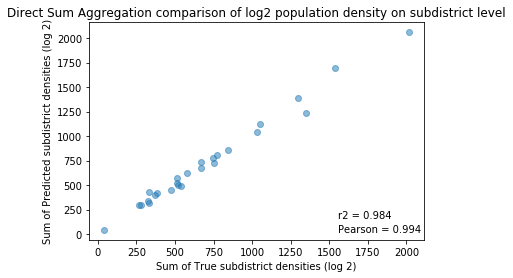

In [11]:
plt.title("Direct Sum Aggregation comparison of log2 population density on subdistrict level")
plt.ylabel("Sum of Predicted subdistrict densities (log 2)")
plt.xlabel("Sum of True subdistrict densities (log 2)")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)
plt.show()

This uses the same methods as the plot shown in the presentation at the end of quarter. The comparison of population density between predition and ground-truth is on subdistrict level, and taking the direct sum of each log2 density value from each subdistrict. It's not a valid comparison, because the subdistricts with more villages would get higher aggregated log2 value, and vice versa. 

It would be better to compare the average population density on subdistricts.

### 2. Direct Average Aggregation comparison

In [12]:
df_direct_log2_ave = df_res.groupby('subdistrict_id')['pop_density_log2', 'pred_log2_density'].agg(np.mean)
true_subdistrict_vals = df_direct_log2_ave.pop_density_log2.values
pred_subdistrict_vals = df_direct_log2_ave.pred_log2_density.values

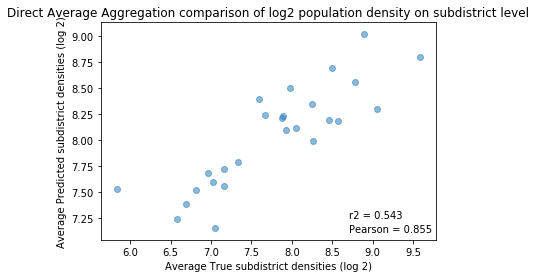

In [13]:
plt.title("Direct Average Aggregation comparison of log2 population density on subdistrict level")
plt.ylabel("Average Predicted subdistrict densities (log 2)")
plt.xlabel("Average True subdistrict densities (log 2)")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)
plt.show()

### 3. Weighted Average Aggregation comparison

In [14]:
df_res['pred_pop'] = df_res.pre_density * df_res.area
df_weighted_sum = df_res.groupby('subdistrict_id')['secc_pop', 'pred_pop','area'].agg(np.sum)
df_weighted_sum['secc_pop_density'] = df_weighted_sum.secc_pop / df_weighted_sum.area
df_weighted_sum['pred_pop_density'] = df_weighted_sum.pred_pop / df_weighted_sum.area
df_weighted_sum['secc_pop_density_log2'] = np.log2(df_weighted_sum.secc_pop_density)
df_weighted_sum['pred_pop_density_log2'] = np.log2(df_weighted_sum.pred_pop_density)
df_weighted_sum.head()

,secc_pop,pred_pop,area,secc_pop_density,pred_pop_density,secc_pop_density_log2,pred_pop_density_log2
subdistrict_id,,,,,,,
3731,29206,22607.944395,124.140994,235.264751,182.115059,7.878141,7.508706
3754,182693,165021.516352,430.495014,424.378899,383.329681,8.729209,8.582442
3766,211726,204892.997762,741.114073,285.686115,276.466209,8.158287,8.110959
3771,90814,108142.099148,356.940331,254.423477,302.969684,7.991088,8.243030
3792,100468,137050.946755,693.491349,144.872752,197.624595,7.178642,7.626619


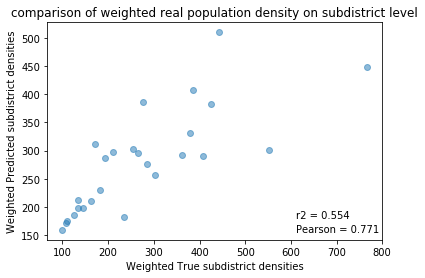

In [15]:
true_subdistrict_vals = df_weighted_sum.secc_pop_density.values
pred_subdistrict_vals = df_weighted_sum.pred_pop_density.values

plt.title("comparison of weighted real population density on subdistrict level")
plt.ylabel("Weighted Predicted subdistrict densities")
plt.xlabel("Weighted True subdistrict densities")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)
plt.show()

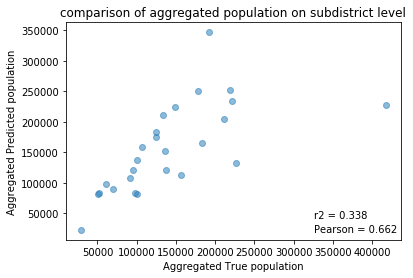

In [16]:
true_subdistrict_vals = df_weighted_sum.secc_pop.values
pred_subdistrict_vals = df_weighted_sum.pred_pop.values

plt.title("comparison of aggregated population on subdistrict level")
plt.ylabel("Aggregated Predicted population")
plt.xlabel("Aggregated True population")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)

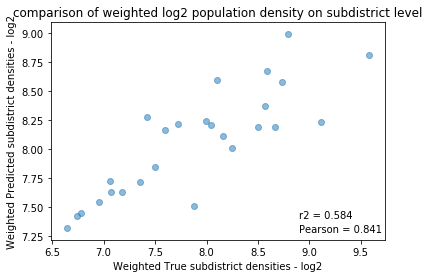

In [17]:
true_subdistrict_vals = df_weighted_sum.secc_pop_density_log2.values
pred_subdistrict_vals = df_weighted_sum.pred_pop_density_log2.values

plt.title("comparison of weighted log2 population density on subdistrict level")
plt.ylabel("Weighted Predicted subdistrict densities - log2")
plt.xlabel("Weighted True subdistrict densities - log2")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)